# SBHAR

dataset  
http://archive.ics.uci.edu/ml/datasets/smartphone-based+recognition+of+human+activities+and+postural+transitions#

https://archive.ics.uci.edu/dataset/341/smartphone+based+recognition+of+human+activities+and+postural+transitions


12 activities collected from 30 participants  
using smartphone sensors (Accelerometer and Gyroscope)  
sampling rate : 50Hz

In [1]:
import os
import pickle
import glob
import pydot
from sklearn import preprocessing
from sklearn.metrics import f1_score
import pandas as pd
import itertools
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure
#plt.rcParams['figure.figsize'] = (6,4) # Make the figures a bit bigger

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hp6pwb1a because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import warnings
warnings.filterwarnings("ignore")

import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


In [3]:
def convert_to_one_hot(class_number, total_classes):
    one_hot = np.zeros(total_classes)
    one_hot[class_number] = 1
    return one_hot

In [4]:
dirout = 'out'
if not os.path.exists(dirout):
    os.makedir(dirout)

## Data load

In [5]:
#data_loc = './data/RawData/'
data_loc = '../Dataset/01_SBHAR_Dataset/RawData/'
labels = np.loadtxt(data_loc + 'labels.txt')

print(data_loc)
print(np.shape(labels))

../Dataset/01_SBHAR_Dataset/RawData/
(1214, 5)


In [6]:
file_list = sorted(glob.glob(data_loc+'*'))
file_list[:3]

['../Dataset/01_SBHAR_Dataset/RawData/acc_exp01_user01.txt',
 '../Dataset/01_SBHAR_Dataset/RawData/acc_exp02_user01.txt',
 '../Dataset/01_SBHAR_Dataset/RawData/acc_exp03_user02.txt']

In [7]:
# Activity labels
motionname=['WALKING',
            'WALKING_UPSTAIRS',
            'WALKING_DOWNSTAIRS',
            'SITTING',
            'STANDING',
            'LAYING',
            'STAND_TO_SIT',
            'SIT_TO_STAND',
            'SIT_TO_LIE',
            'LIE_TO_SIT',
            'STAND_TO_LIE',
            'LIE_TO_STAND']

feature_name = ['acc_x', 'acc_y', 'acc_z',  'ang_x', 'ang_y', 'ang_z']

In [8]:
labels = labels.astype(int)

In [9]:
labels

array([[    1,     1,     5,   250,  1232],
       [    1,     1,     7,  1233,  1392],
       [    1,     1,     4,  1393,  2194],
       ...,
       [   61,    30,     2, 15588, 16319],
       [   61,    30,     3, 16546, 17250],
       [   61,    30,     2, 17394, 18097]])

```
Column 1: experiment number ID,
Column 2: user number ID,
Column 3: activity number ID
Column 4: Label start point (in number of signal log samples)
Column 5: Label end point (in number of signal log samples)
```

* experiment number ID 는 파일명에서 보듯 실험단위로 1~61까지 총 61번의 실험.  
* user number ID 는 실험에 참여한 사람의 고유번호 1~30 까지 총 30 명.  
* activity number ID 는 참여자가 하고 있는 동작의 번호로 총 1~12 까지 12 동작.

In [10]:
np.unique(labels[:,0])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [11]:
load_from_pickle = True

outdir_pickle = './pickle/SBHAR'
overlab = False
nsample_crop = 100 #100 #150
n_classes = len(motionname)

In [12]:
fn_pickle = '{}/dataset_{}_23.pickle'.format(outdir_pickle, nsample_crop)

if load_from_pickle:
    if os.path.exists(fn_pickle):
        print('{} exists....OK'.format(fn_pickle))
    else:
        print('{} does NOT exists....'.format(fn_pickle))
        load_from_pickle = False
        print('loadFromPickle....{}'.format(load_from_pickle))
        print('System will load data from RAW files')
        if not os.path.exists(outdir_pickle):
            os.makedirs(outdir_pickle)

../pickle/SBHAR/dataset_100_23.pickle does NOT exists....
loadFromPickle....False
System will load data from RAW files


In [13]:
if not load_from_pickle:
    acc_data = []
    gyro_data = []
    y_true = []
    for i in tqdm(range(len(labels))):
        fn_acc_temp = glob.glob(data_loc + 'acc_exp{:02d}*.txt'.format(labels[i][0])) #Column 1: experiment number ID,
        acc_full = np.loadtxt(fn_acc_temp[0], dtype='float')
        fn_gyro_temp = glob.glob(data_loc + 'gyro_exp{:02d}*.txt'.format(labels[i][0]))
        gyro_full = np.loadtxt(fn_gyro_temp[0], dtype='float')
        y_temp = labels[i][2]
        if overlab == True:
            window_num = int(((labels[i][4])-(labels[i][3]+nsample_crop/2))//(nsample_crop/2))
            for j in range(window_num):
                start = int(labels[i][3]+(j*(nsample_crop/2))-1)
                end = int(start + nsample_crop)
                acc_temp = acc_full[start:end][:]
                gyro_temp = gyro_full[start:end][:]
                acc_data.append(acc_temp)
                gyro_data.append(gyro_temp)
                y_true.append(y_temp)
        else:
            window_num = int((labels[i][4]-labels[i][3])//nsample_crop)
            for j in range(window_num):
                start = int(labels[i][3]+(j*(nsample_crop)))
                end = int(start + nsample_crop)
                acc_temp = acc_full[start:end][:]
                gyro_temp = gyro_full[start:end][:]
                acc_data.append(acc_temp)
                gyro_data.append(gyro_temp)
                y_true.append(y_temp)

100%|██████████| 1214/1214 [00:35<00:00, 34.62it/s]


In [14]:
np.shape(acc_data), np.shape(gyro_data), np.shape(y_true)

((7551, 100, 3), (7551, 100, 3), (7551,))

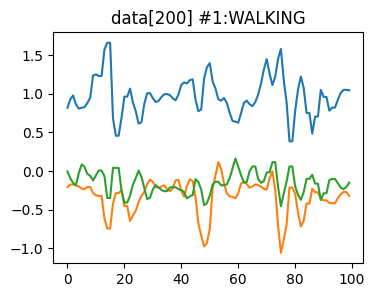

In [15]:
idx_to_draw = 200

plt.figure(figsize=(4,3))
plt.plot(acc_data[idx_to_draw])
plt.title('data[{}] #{}:{}'.format(idx_to_draw, y_true[idx_to_draw], motionname[np.argmax(y_true[idx_to_draw])]))
plt.show()

In [16]:
data_all = np.concatenate([acc_data, gyro_data], axis=-1)
print(np.shape(data_all))

(7551, 100, 6)


In [17]:
acc_data = np.array(acc_data)
gyro_data = np.array(gyro_data)
y_true = np.array(y_true)
y_true_onehot = []
for i in range(len(y_true)):
    y_true_onehot.append(convert_to_one_hot(y_true[i]-1,n_classes))
y_true_onehot = np.array(y_true_onehot)

In [18]:
for i in range(1):
    indices = np.where(y_true == i+1) 
    vdata = data_all[indices,:,:]   
    vlabel = y_true_onehot[indices,:]
    print(np.shape(vdata))
    print(np.shape(vlabel))
    print(vlabel)
    vdata = vdata.reshape(vdata.shape[1], vdata.shape[2], vdata.shape[3])
    print(np.shape(vdata))

(1, 1162, 100, 6)
(1, 1162, 12)
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
(1162, 100, 6)


In [19]:
indices

(array([  60,   61,   62, ..., 7508, 7509, 7510]),)

In [20]:
vdatac = [None] * n_classes
vlabelc = [None] * n_classes
for i in range(n_classes):
    vdata = []
    vlabel = []
    indices = np.where(y_true == i+1)  #y_true 가 해당 동작 번호일때의 index값을 반환
    vdata = data_all[indices,:,:]   # 예를들어 전체 데이터인 data_all의 (10908, 128, 6)개 중에서 1번동작일때만 뽑으면 (1, 1720, 128, 6)
    vlabel = y_true_onehot[indices,:]
    vdatac[i] = np.array(vdata)
    vdatac[i] = vdatac[i].reshape(vdatac[i].shape[1], vdatac[i].shape[2], vdatac[i].shape[3])
    vlabelc[i] = np.array(vlabel)
    vlabelc[i] = vlabelc[i].reshape(vlabelc[i].shape[1], vlabelc[i].shape[2])
    print('{}\t{}'.format(vdatac[i].shape, vlabelc[i].shape))    

(1162, 100, 6)	(1162, 12)
(1079, 100, 6)	(1079, 12)
(982, 100, 6)	(982, 12)
(1212, 100, 6)	(1212, 12)
(1317, 100, 6)	(1317, 12)
(1312, 100, 6)	(1312, 12)
(74, 100, 6)	(74, 12)
(54, 100, 6)	(54, 12)
(95, 100, 6)	(95, 12)
(77, 100, 6)	(77, 12)
(113, 100, 6)	(113, 12)
(74, 100, 6)	(74, 12)


In [21]:
for i in range(n_classes):
    print(i,'\t', motionname[i], '\t', np.shape(vdatac[i])[0],'\t',  round(np.shape(vdatac[i])[0]*nsample_crop*20/1000/60, 1), 'min / ', '\t\t',round(np.shape(vdatac[i])[0]*nsample_crop*20/1000/60/60, 2),'hrs')

0 	 WALKING 	 1162 	 38.7 min /  		 0.65 hrs
1 	 WALKING_UPSTAIRS 	 1079 	 36.0 min /  		 0.6 hrs
2 	 WALKING_DOWNSTAIRS 	 982 	 32.7 min /  		 0.55 hrs
3 	 SITTING 	 1212 	 40.4 min /  		 0.67 hrs
4 	 STANDING 	 1317 	 43.9 min /  		 0.73 hrs
5 	 LAYING 	 1312 	 43.7 min /  		 0.73 hrs
6 	 STAND_TO_SIT 	 74 	 2.5 min /  		 0.04 hrs
7 	 SIT_TO_STAND 	 54 	 1.8 min /  		 0.03 hrs
8 	 SIT_TO_LIE 	 95 	 3.2 min /  		 0.05 hrs
9 	 LIE_TO_SIT 	 77 	 2.6 min /  		 0.04 hrs
10 	 STAND_TO_LIE 	 113 	 3.8 min /  		 0.06 hrs
11 	 LIE_TO_STAND 	 74 	 2.5 min /  		 0.04 hrs


In [22]:
print('Shuffled data...')
for i in range(n_classes):
    np.random.shuffle(vdatac[i])
print('Okay')

Shuffled data...
Okay


In [23]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_time_series_data(datas):
    length = np.shape(datas[0])[1]
    dim = np.shape(datas[0])[2]
    # Combine all the data
    all_data = np.concatenate(datas, axis=0)
    all_data = all_data.reshape(-1, dim)
    
    # Initialize a StandardScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data and scale it
    all_data = scaler.fit_transform(all_data)

    # Initialize an empty list to store the start indices of each class
    start_indices = [0]

    # Calculate the start index of each class
    for data in datas:
        start_indices.append(start_indices[-1] + len(data))

    all_data = all_data.reshape(-1, length, dim)
    # Split the combined data into the original classes
    scaled_datas = [all_data[start_indices[i]:start_indices[i+1]] for i in range(len(start_indices)-1)]

    return scaled_datas, scaler

In [24]:
# 데이터 정규화
datac_all_norm, scaler = scale_time_series_data(vdatac)

In [25]:
# idx_to_draw = 1
# fig1, axarr = plt.subplots(nrows = n_classes, ncols = 2, sharex=True, figsize=(15, 20))
# for i in range(n_classes):
#     for j in range(2):
#         axarr[i][j].plot((datac_all_norm[i][idx_to_draw])[:,j*3:j*3+3])#[j*3:j*3+3])
#         axarr[i][j].set_title('Activity #{} {} Idx #{}'.format(i+1, motionname[i], idx_to_draw ))
# plt.tight_layout(pad=2)
# plt.show()

In [26]:
from sklearn.model_selection import train_test_split

def split_data_and_labels(datas, labels, test_size=0.2):
    data_train = []
    data_test = []
    labels_train = []
    labels_test = []

    for data, label in zip(datas, labels):
        data_tr, data_te, label_tr, label_te = train_test_split(data, label, test_size=test_size, random_state=42)
        data_train.append(data_tr)
        data_test.append(data_te)
        labels_train.append(label_tr)
        labels_test.append(label_te)

    return data_train, data_test, labels_train, labels_test

In [27]:
data_train, data_test, labels_train, labels_test = split_data_and_labels(datac_all_norm, vlabelc)

In [28]:
sz_train = []
sz_test = []

for i in range(n_classes):
    print(np.shape(data_train[i]), np.shape(data_test[i]))
    sz_train.append(len(data_train[i]))
    sz_test.append(len(data_test[i]))
    if i == 0:
        trainX = data_train[i]
        trainy = labels_train[i]
        
        testX = data_test[i]
        testy = labels_test[i]
    else:
        trainX   = np.vstack((trainX, data_train[i]))
        trainy = np.vstack((trainy, labels_train[i]))
        
        testX   = np.vstack((testX, data_test[i]))
        testy = np.vstack((testy, labels_test[i]))

(929, 100, 6) (233, 100, 6)
(863, 100, 6) (216, 100, 6)
(785, 100, 6) (197, 100, 6)
(969, 100, 6) (243, 100, 6)
(1053, 100, 6) (264, 100, 6)
(1049, 100, 6) (263, 100, 6)
(59, 100, 6) (15, 100, 6)
(43, 100, 6) (11, 100, 6)
(76, 100, 6) (19, 100, 6)
(61, 100, 6) (16, 100, 6)
(90, 100, 6) (23, 100, 6)
(59, 100, 6) (15, 100, 6)


In [33]:
prinsz_train

[929, 863, 785, 969, 1053, 1049, 59, 43, 76, 61, 90, 59]

In [29]:
print(np.shape(trainX))
print(np.shape(trainy))
print(np.shape(testX))
print(np.shape(testy))

(6036, 100, 6)
(6036, 12)
(1515, 100, 6)
(1515, 12)


In [30]:
class_name = motionname

In [34]:
loadFromPickle = False

In [35]:
outdir_pickle = './pickle/SBHAR'
fn_pickle_pub = '{}/SBHAR_class{}_len{}_pub_23.pickle'.format(outdir_pickle, n_classes, nsample_crop)
print(fn_pickle_pub)

if not os.path.exists(outdir_pickle):
    os.mkdir(outdir_pickle)

if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))
    else:
        print('{} does NOT exists....'.format(fn_pickle_pub))
        loadFromPickle = False
        print('loadFromPickle....{}'.format(loadFromPickle))
        

if not loadFromPickle:
    datasave = [None] * 9
    datasave[0] = trainX
    datasave[1] = trainy
    datasave[2] = testX
    datasave[3] = testy
    datasave[4] = class_name
    datasave[5] = feature_name
    datasave[6] = scaler 
    datasave[7] = sz_train
    datasave[8] = sz_test

    file = open(fn_pickle_pub, 'wb')
    pickle.dump(datasave, file)
    file.close()

    print('-------------------------------------------')
    print('# Saved files for publication\n ---> \n{}'.format(fn_pickle_pub)) #과제 공개 데이터
    print('-------------------------------------------')

else:
    print('load from pickle files')
    file = open(fn_pickle_pub, 'rb')
    data = pickle.load(file)
    file.close()
    
    trainX = data[0]
    trainy = data[1]  
    testX = data[2]  
    testy = data[3] 
    class_name_pub = data[4] 
    feature_name = data[5]
    scaler = data[6]
    sz_train = data[7]
    sz_test = data[8]

../pickle/SBHAR/SBHAR_class12_len100_pub_23.pickle
-------------------------------------------
# Saved files for publication
 ---> 
../pickle/SBHAR/SBHAR_class12_len100_pub_23.pickle
-------------------------------------------


In [36]:
# # 데이터 시각화
# f, ax = plt.subplots(n_classes, 1, figsize=(8,8), squeeze=False, sharex=True)
# for i in range(n_classes):
#     ax[i//1, i%1].plot(data_train[i][200])
#     ax[i//1, i%1].set_title('{}'.format(class_name[i]))
# plt.tight_layout(pad=0.3)
# plt.show()